# Estimating the correlation length 

* The correlation length $L$ determines whether two points separated by a given distance are correlated or not.
* `DIVAnd` includes several tools to estimate the correlation length.
* We will start with a 2D case and consider the 3D case.

In [1]:
using DIVAnd
using Makie
using CairoMakie
using GeoMakie
using Dates
using Statistics
using Random
using Printf
include("../config.jl")

"https://dox.uliege.be/index.php/s/h8d3pyqmuea6J9H/download"

## Data reading

The file `WOD-Salinity-Provencal.nc` contains salinity measurement obtained from the [World Ocean Database](https://www.nodc.noaa.gov/OC5/WOD/pr_wod.html). for the Provençal Basin (Mediterranean Sea). The profiles were not interpolated vertically.

The resulting correlation length can fluctuate a bit between runs, because the correlation is based on a collection of random pairs. 

### 2D case

* First lets consider only the data on a 2D surface (longitude and latitude)
* Load the data file if it is not already present.

In [2]:
varname = "Salinity"
download_check(salinityprovencalfile, salinityprovencalfileURL)

bathname = gebco04file
download_check(gebco04file, gebco04fileURL)

lonr = 3.:0.1:11.8
latr = 42.:0.1:44.5
depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];
bathisglobal = true

[ Info: File already downloaded
[ Info: File already downloaded


true

### Extract the bathymetry and mask for plotting

In [3]:
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);
_,_,mask = load_mask(bathname,bathisglobal,lonr,latr,depthr);

Load the data and print basic information about it that can be used for quality check.

In [4]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,salinityprovencalfile,"Salinity")
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (3.0418334007263184, 11.8100004196167)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (-0.0, 2762.0)
              minimum and maximum of obs. dimension 4: (DateTime("1892-09-25T00:00:00"), DateTime("2017-10-02T06:14:02.761"))
                          minimum and maximum of data: (0.25, 40.0)


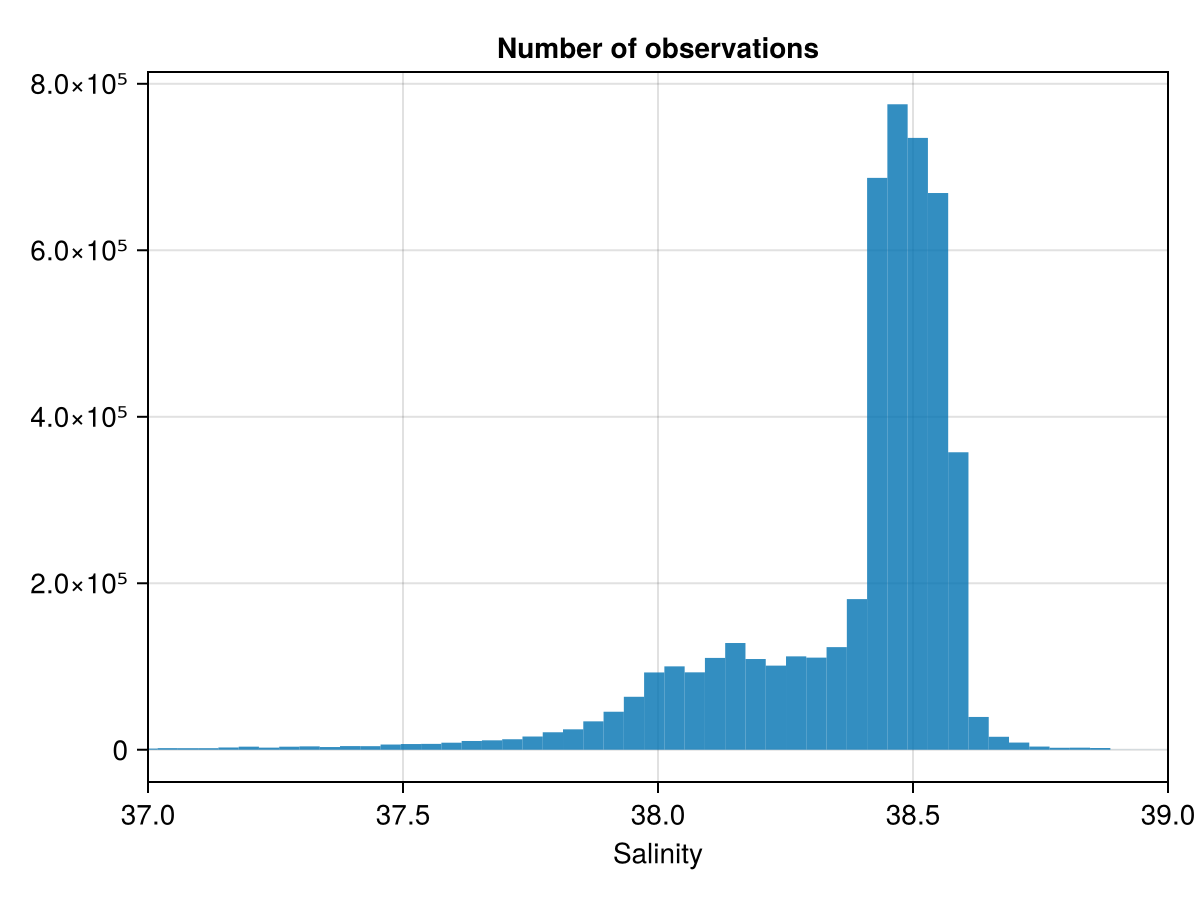

In [5]:
f = Figure()
ax = Axis(f[1, 1], xlabel = "Salinity", title = "Number of observations")
hist!(ax, obsval, bins=1000)
xlims!(ax, 37,39)
f

### Removing suspect observations
⚠️ It is quite important to remove outliers for the correlation length estimation, as they can have a significant impact.

For this example we select only the first month (January) and we remove some questionable data

In [6]:
badid = ["wod_015600782O","wod_015602753O","wod_015604717O","wod_015606732O",
         "wod_015607117O","wod_015607524O","wod_015607893O","wod_015924970O",
         "wod_015926914O","wod_015928739O","wod_016650545O","wod_008518725O",
         "wod_007643915O","wod_015875365O","wod_006614816O","wod_006614929O",
         "wod_006614937O","wod_007644875O","wod_009996947O","wod_010742471O",
         "wod_010742472O","wod_006614931O","wod_006614934O","wod_006625408O",
         "wod_006752127O","wod_006752129O"];

good = (37.6 .< obsval .< 38.75) .& map(id -> !(id in badid),obsid)


sel = (Dates.month.(obstime) .== 1) .& good
x = (obslon[sel],obslat[sel],obsdepth[sel]);
v = obsval[sel];
z = depthr;

### Data plot
Plot the observation at a given level. What do you think will happend if you run `plotobs.(z)`?

In [7]:
function plotobs(z)

    sel = (Dates.month.(obstime) .== 1) .& (abs.(obsdepth .- z) .< 50)  .& good # .& (obsval .< 38.3)

    fig = Figure()
    ga = GeoAxis(fig[1, 1];  dest = "+proj=merc", title = "Depth: $(z[1]) m ($(sum(sel)) osbervations)")
    sc = scatter!(ga, obslon[sel],obslat[sel], color=obsval[sel])
    contourf!(ga, bx, by, b, levels=[-1e5,0, 1.], colormap=Reverse(:binary))
    Colorbar(fig[2, 1], sc, vertical = false, label = "S")
    #GeoMakie.xlims!(ga, (lonr[1], lonr[end]))
    #GeoMakie.ylims!(ga, (latr[1], latr[end]))
    fig
end

plotobs (generic function with 1 method)

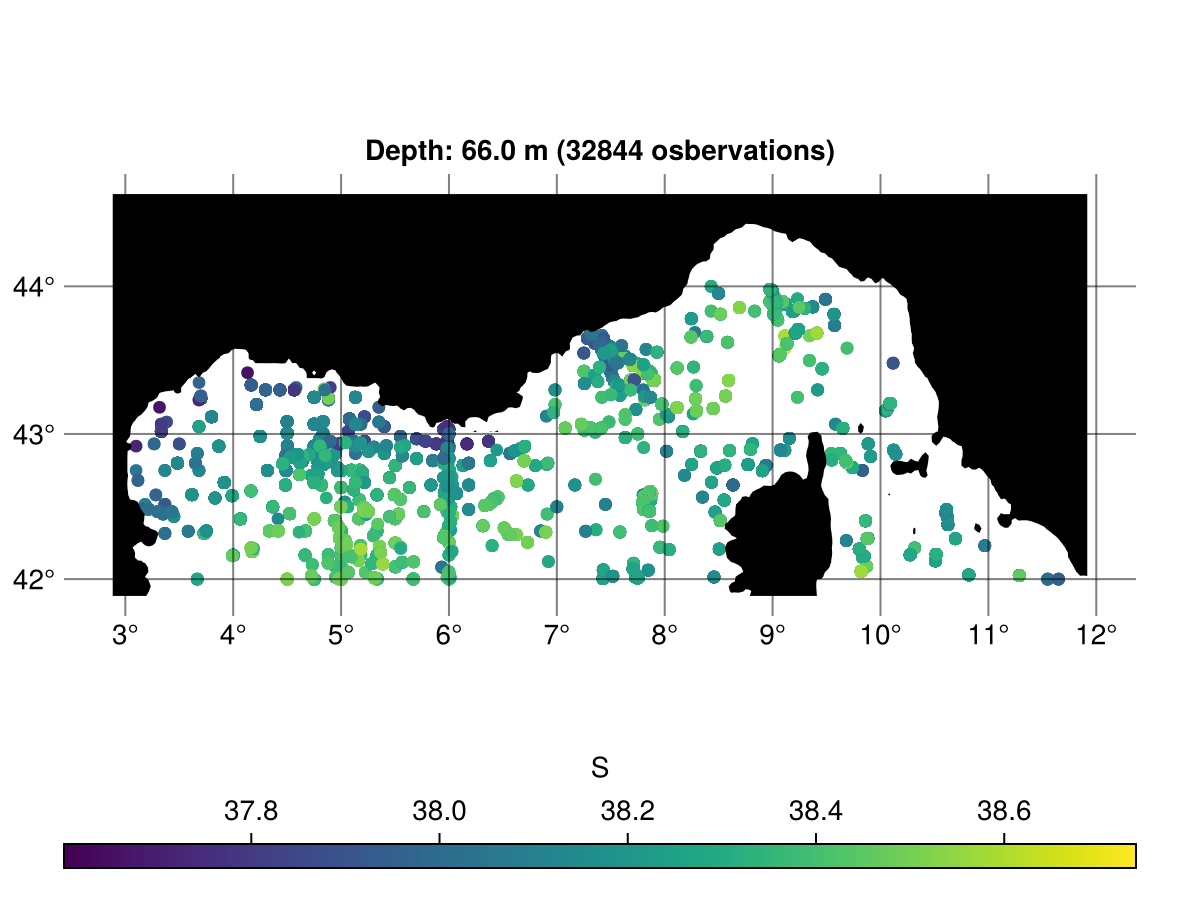

In [8]:
plotobs(z[10])

## Analysis

Prepare the domain, mask and background field.

In [9]:
mask, pmn, xyi = DIVAnd.domain(bathname, bathisglobal, lonr, latr, depthr)
sz = size(mask);
# obs. coordinate matching selection
xsel = (obslon[sel],obslat[sel],obsdepth[sel])

vm = mean(obsval[sel])
va = obsval[sel] .- vm
toaverage = [true, true, false]
background_len = (zeros(sz),zeros(sz),fill(50.,sz))
background_epsilon2 = 1000.


fi, vaa = DIVAnd.DIVAnd_averaged_bg(
    mask,
    pmn,
    xyi,
    xsel,
    va,
    background_len,
    background_epsilon2,
    toaverage;
)

fbackground = fi .+ vm
@debug "fbackground: $(fbackground[1,1,:])"

v = vaa;
sel2 = isfinite.(v)
x = (xsel[1][sel2],xsel[2][sel2],xsel[3][sel2])
v = v[sel2];

### Plotting the background

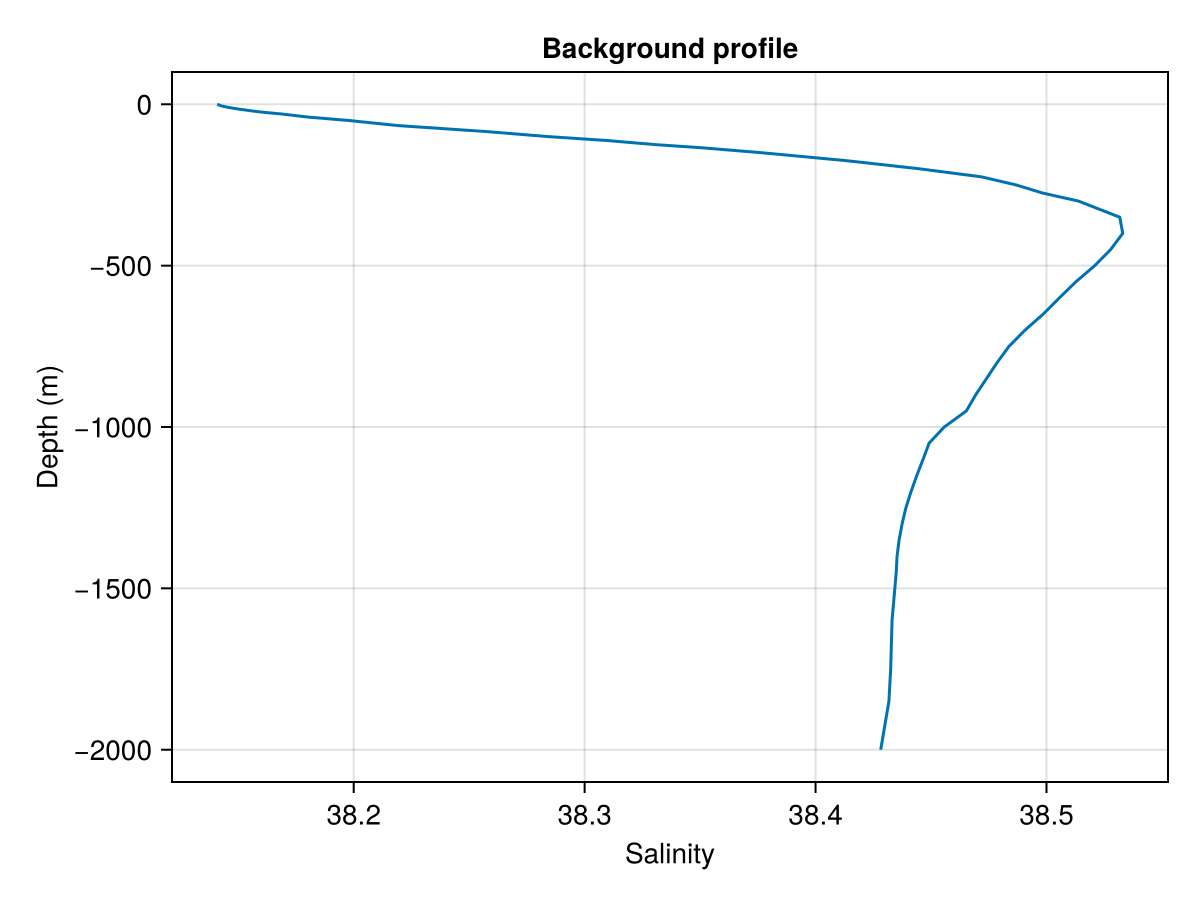

In [10]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Salinity", ylabel="Depth (m)", title = "Background profile")
lines!(ax, fbackground[1,1,:], -depthr)
fig

## Horizontal correlation length
Estimate the horizontal correlation length for different depth levels, using the function `fithorzlen`  
(can take a few minutes).

In [11]:
@time lenxy,infoxy = fithorzlen(x,v,[0.]);

[ Info: Data points at z=0.0: 17698, horz. correlation length: 0.19358645017246312 (preliminary)


  4.918590 seconds (78.62 M allocations: 3.167 GiB, 18.28% gc time, 62.46% compilation time)


[ Info: Smoothed horz. correlation length at z=0.0: 0.19358645017246312


The function `fithorzlen` can take optional arguments:
- `distfun`: the function used to get the distance between two points (default: the Euclidian distance);
- `searchz`: the vertical search distance (distance taken the distance of interest; 50 meters by default). 

In [12]:
@time lenxy,infoxy = fithorzlen(x,v,z; distfun = DIVAnd.distfun_m, searchz = z -> (z/4+10));

[ Info: Data points at z=0.0: 3365, horz. correlation length: 16562.01510126352 (preliminary)
[ Info: Data points at z=5.0: 5739, horz. correlation length: 16868.800415212412 (preliminary)
[ Info: Data points at z=10.0: 8072, horz. correlation length: 16148.78889829363 (preliminary)
[ Info: Data points at z=15.0: 9573, horz. correlation length: 17226.50616782353 (preliminary)
[ Info: Data points at z=20.0: 10929, horz. correlation length: 17755.731799691122 (preliminary)
[ Info: Data points at z=25.0: 11921, horz. correlation length: 17174.397661069284 (preliminary)
[ Info: Data points at z=30.0: 12284, horz. correlation length: 18055.2245771969 (preliminary)
[ Info: Data points at z=40.0: 13748, horz. correlation length: 17097.148515646597 (preliminary)
[ Info: Data points at z=50.0: 15289, horz. correlation length: 16417.36146916015 (preliminary)
[ Info: Data points at z=66.0: 17637, horz. correlation length: 14922.307267968341 (preliminary)
[ Info: Data points at z=75.0: 18861, horz

108.117177 seconds (1.27 G allocations: 56.605 GiB, 6.54% gc time, 1.46% compilation time)


[ Info: Data points at z=2000.0: 22368, horz. correlation length: 13900.290185752498 (preliminary)
[ Info: Smoothed horz. correlation length at z=0.0: 14504.892121354527
[ Info: Smoothed horz. correlation length at z=5.0: 14498.72677219741
[ Info: Smoothed horz. correlation length at z=10.0: 14486.469377603456
[ Info: Smoothed horz. correlation length at z=15.0: 14468.266948634626
[ Info: Smoothed horz. correlation length at z=20.0: 14444.341012867015
[ Info: Smoothed horz. correlation length at z=25.0: 14414.988832817946
[ Info: Smoothed horz. correlation length at z=30.0: 14380.58503879454
[ Info: Smoothed horz. correlation length at z=40.0: 14297.980017949889
[ Info: Smoothed horz. correlation length at z=50.0: 14201.600623641012
[ Info: Smoothed horz. correlation length at z=66.0: 14031.266267674797
[ Info: Smoothed horz. correlation length at z=75.0: 13941.193394490683
[ Info: Smoothed horz. correlation length at z=85.0: 13854.748915113012
[ Info: Smoothed horz. correlation length

One can get information about the fitting and its quality using the object `infoxy`:

In [13]:
infoxy[:fitinfos][1]

Dict{Symbol, Any} with 8 entries:
  :sn          => 0.586164
  :rqual       => 0.904404
  :fitcovar    => [NaN, 0.0107166, 0.0102169, 0.00960594, 0.00894556, 0.0082716…
  :meandist    => 1.74705e5
  :covar       => [0.0146215, 0.012189, 0.00960122, 0.00825661, 0.00772824, 0.0…
  :range       => 2:23
  :distx       => 0.0:2183.810008077996:705370.6326091926
  :covarweight => [7.34537e13, 7.34428e13, 7.36617e13, 7.34977e13, 7.34506e13, …

Extract the information for the level `k = 1`:
* `covar`: the empirical covariance
* `fitcovar`: the fitted empirical covariance
* `distx`: distance
* `range`: part of `covar` used for the fitting
* `rqual`: the quality for the fit (1: excellent, 0: poor)

In [14]:
k = 1
covar = infoxy[:fitinfos][k][:covar]
fitcovar = infoxy[:fitinfos][k][:fitcovar]
distx = infoxy[:fitinfos][k][:distx]
range = infoxy[:fitinfos][k][:range]
rqual = infoxy[:fitinfos][k][:rqual]

0.9044041154568527

### Create plots

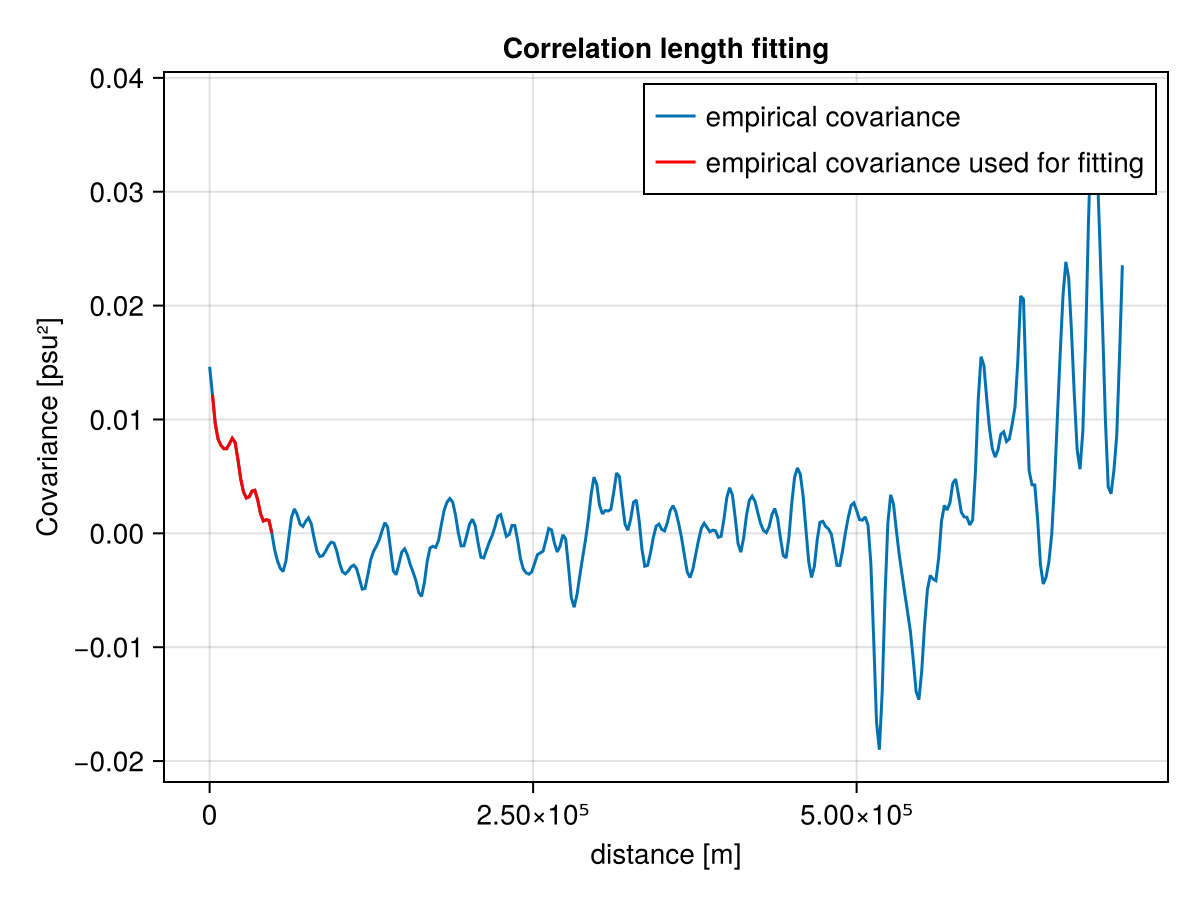

In [15]:
fig = Figure()
ax = Axis(fig[1, 1], ylabel = "Covariance [psu²]", xlabel="distance [m]", title = "Correlation length fitting")
lines!(distx,covar,label="empirical covariance")
lines!(distx[range],covar[range],color=:red,label="empirical covariance used for fitting")
axislegend()
fig

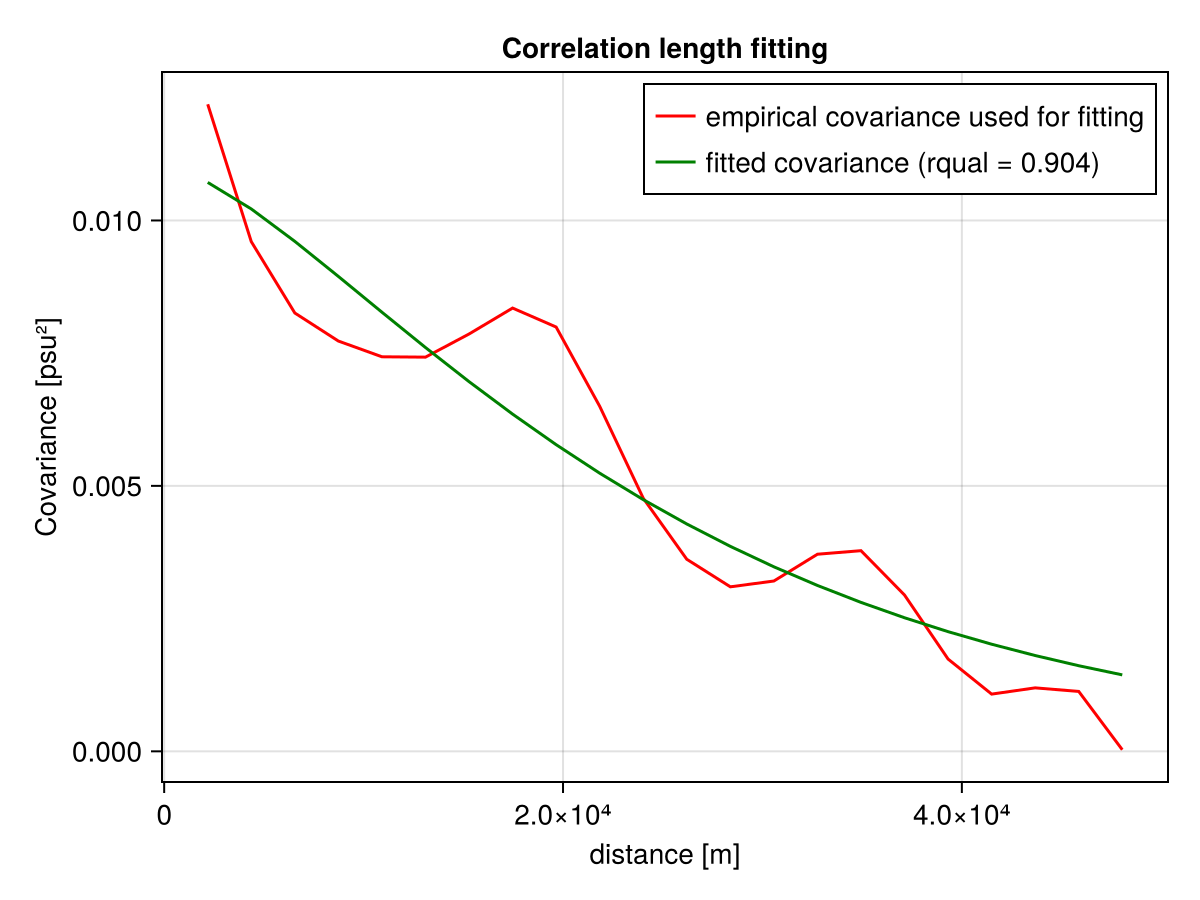

In [16]:
fig = Figure()
ax = Axis(fig[1, 1], ylabel = "Covariance [psu²]", xlabel="distance [m]", title = "Correlation length fitting")
lines!(distx[range],covar[range],color=:red,label="empirical covariance used for fitting")
lines!(distx[range],fitcovar[range],color=:green,
label="fitted covariance (rqual = $(@sprintf("%4.3f",rqual)))")
axislegend(ax)
fig

🖋️ Try different values of k (the level index) and re-run the previous two cells.     
Note that at some level the fit was quite poor. Additional filtering (vertically) is done to smooth the horizontal correlation length.

### Horizontal correlation length with respect to the depth
For the deepest layers, there is less observations, hence the decreasing quality of the fit.

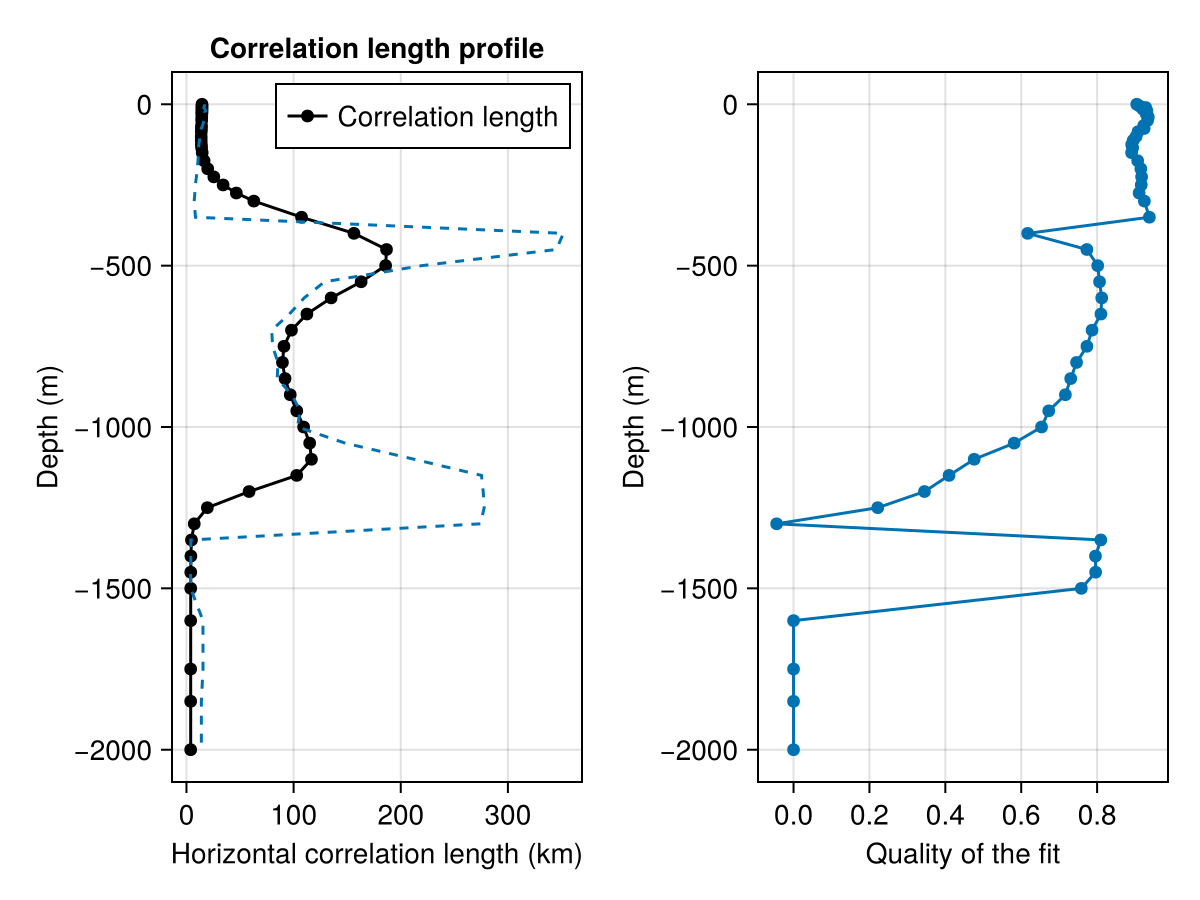

In [17]:
rqual = [f[:rqual] for f in infoxy[:fitinfos]]

fig = Figure()
ax1 = Axis(fig[1, 1], ylabel = "Depth (m)", xlabel="Horizontal correlation length (km)", 
title = "Correlation length profile")
scatterlines!(ax1, lenxy/1000,-z, color=:black, label="Correlation length")
lines!(ax1, infoxy[:len]/1000,-z, linestyle=:dash)
axislegend(ax1)

ax2 = Axis(fig[1, 2], ylabel = "Depth (m)", xlabel="Quality of the fit")
scatterlines!(ax2, rqual,-z)
fig

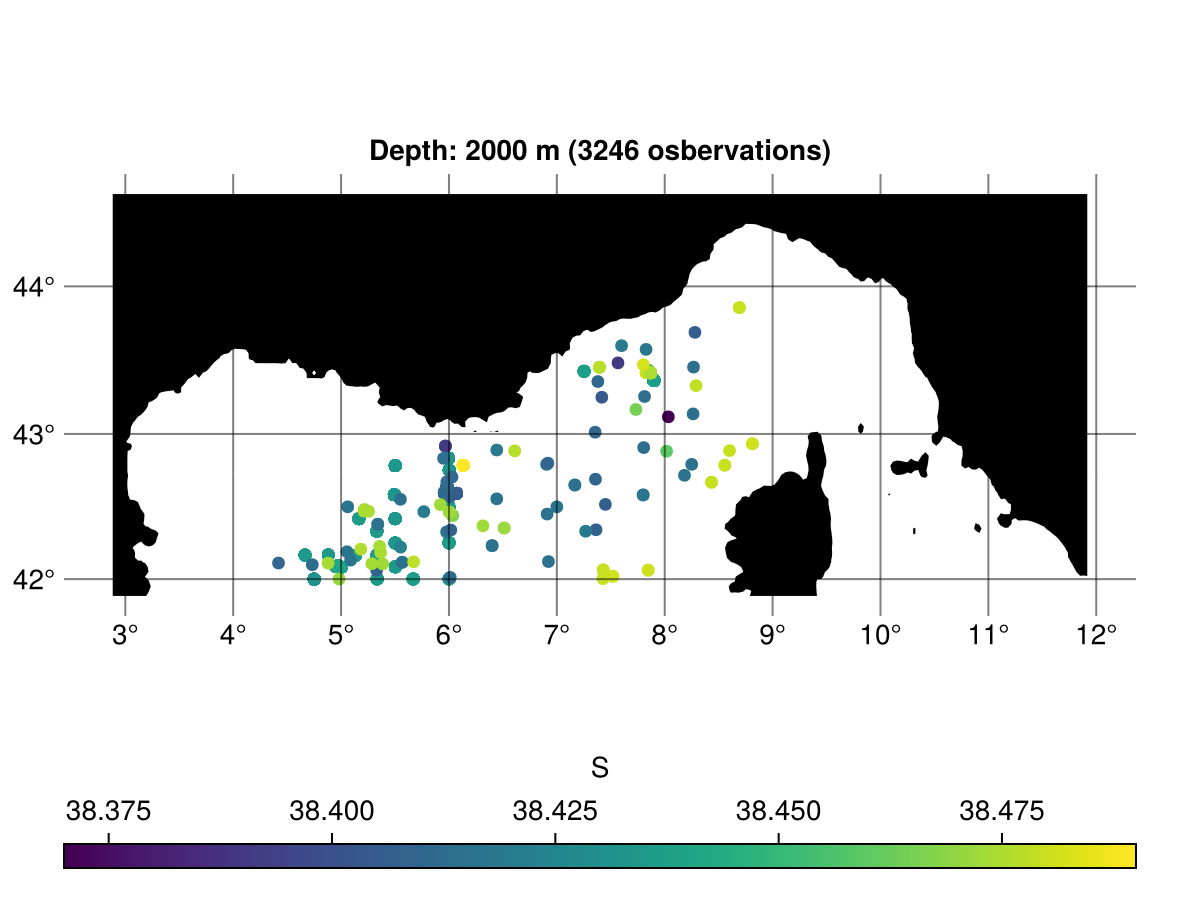

In [18]:
plotobs.(2000)

It is useful to limit the acceptable range of the correlation length by providing a function `limitfun` with the argument depth `z` and estimated correlation length `len`.     
It then returns the adjusted correlation length. This adjustememt is done before the filtering.

In [19]:
@time lenxy2,infoxy2 = fithorzlen(x,v,z; distfun = DIVAnd.distfun_m, 
limitfun = (z,len) -> min(max(len,25e3),60e3));

[ Info: Data points at z=0.0: 17698, horz. correlation length: 16643.396735389724 (preliminary)
[ Info: Data points at z=5.0: 19460, horz. correlation length: 16669.767867154238 (preliminary)
[ Info: Data points at z=10.0: 21024, horz. correlation length: 16468.55603894042 (preliminary)
[ Info: Data points at z=15.0: 22717, horz. correlation length: 16809.237020630215 (preliminary)
[ Info: Data points at z=20.0: 24290, horz. correlation length: 16589.379821845592 (preliminary)
[ Info: Data points at z=25.0: 26100, horz. correlation length: 16600.180068866604 (preliminary)
[ Info: Data points at z=30.0: 27819, horz. correlation length: 15635.382911013481 (preliminary)
[ Info: Data points at z=40.0: 30940, horz. correlation length: 15555.548079681936 (preliminary)
[ Info: Data points at z=50.0: 33527, horz. correlation length: 15335.997561399541 (preliminary)
[ Info: Data points at z=66.0: 32844, horz. correlation length: 14382.77330682853 (preliminary)
[ Info: Data points at z=75.0: 321

108.959945 seconds (1.24 G allocations: 55.241 GiB, 7.18% gc time, 0.38% compilation time)


[ Info: Data points at z=2000.0: 1823, horz. correlation length: 12362.243838886516 (preliminary)
[ Info: Smoothed horz. correlation length at z=0.0: 25005.82785063225
[ Info: Smoothed horz. correlation length at z=5.0: 25006.021171345557
[ Info: Smoothed horz. correlation length at z=10.0: 25006.412612723492
[ Info: Smoothed horz. correlation length at z=15.0: 25007.011848062655
[ Info: Smoothed horz. correlation length at z=20.0: 25007.833571009556
[ Info: Smoothed horz. correlation length at z=25.0: 25008.89771660235
[ Info: Smoothed horz. correlation length at z=30.0: 25010.229756972312
[ Info: Smoothed horz. correlation length at z=40.0: 25013.79220718771
[ Info: Smoothed horz. correlation length at z=50.0: 25018.879344469377
[ Info: Smoothed horz. correlation length at z=66.0: 25031.125335733486
[ Info: Smoothed horz. correlation length at z=75.0: 25041.36834770123
[ Info: Smoothed horz. correlation length at z=85.0: 25056.333149726852
[ Info: Smoothed horz. correlation length at

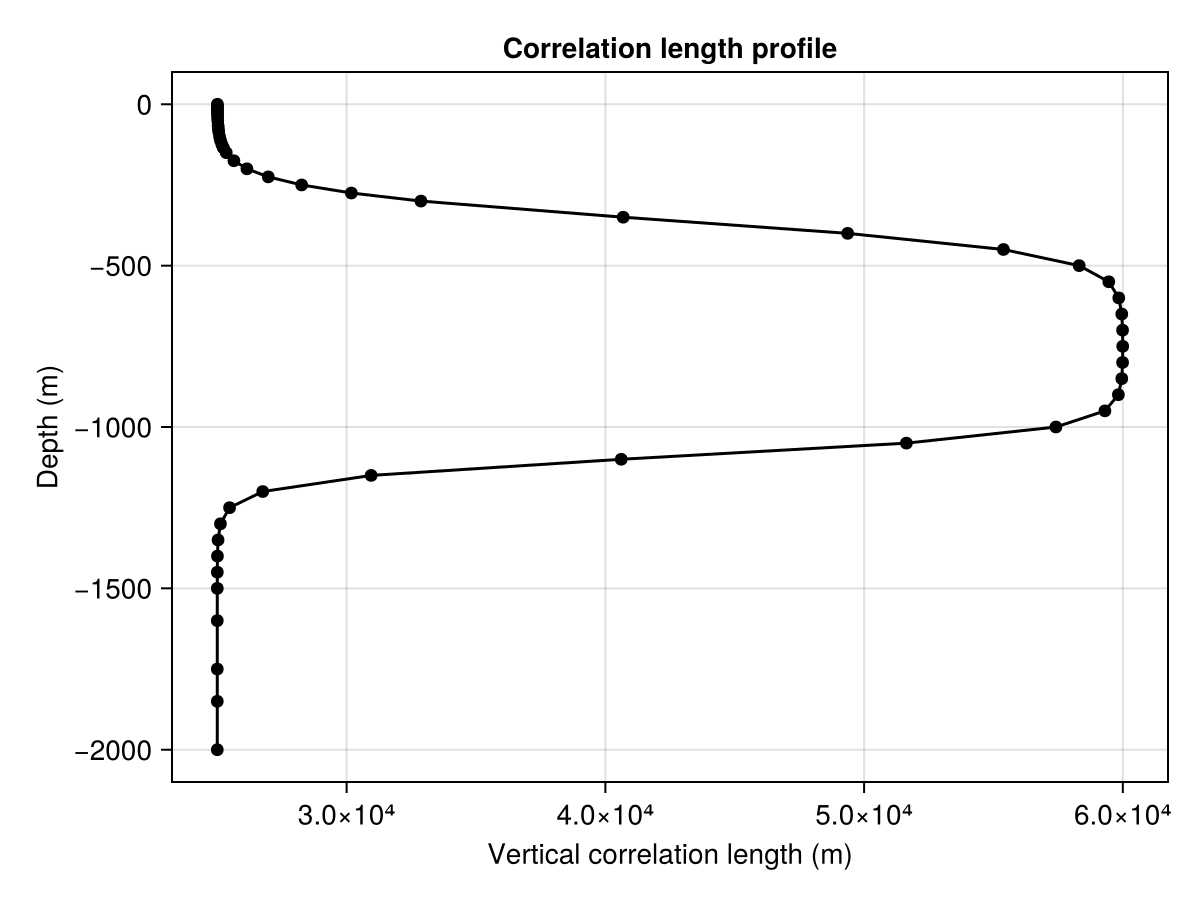

In [20]:
fig = Figure()
ax1 = Axis(fig[1, 1], ylabel = "Depth (m)", xlabel="Vertical correlation length (m)", 
title = "Correlation length profile")
scatterlines!(ax1, lenxy2,-z, color=:black)
#plot(infoxy2[:len],-z,":");
fig

## Vertical correlation length 
The vertical correlation length is also estimated for different depth levels

In [21]:
?fitvertlen

search: fitvertlen fithorzlen iterate



```
lenz,dbinfo = DIVAnd.fitvertlen(x,value,z,...)
```

See also DIVAnd.fithorzlen


In [22]:
lenz,infoz = fitvertlen(x,v,z);

[ Info: Vert. correlation length at z=0.0: 83.26944
[ Info: Vert. correlation length at z=5.0: 95.80415167968752
[ Info: Vert. correlation length at z=10.0: 108.39144289062881
[ Info: Vert. correlation length at z=15.0: 97.04721625350952
[ Info: Vert. correlation length at z=20.0: 145.65907505676273
[ Info: Vert. correlation length at z=25.0: 83.55359999999999
[ Info: Vert. correlation length at z=30.0: 88.88837227368165
[ Info: Vert. correlation length at z=40.0: 86.53482256488039
[ Info: Vert. correlation length at z=50.0: 83.4860117775879
[ Info: Vert. correlation length at z=66.0: 87.7091978100586
[ Info: Vert. correlation length at z=75.0: 95.47000001037597
[ Info: Vert. correlation length at z=85.0: 92.94411540209964
[ Info: Vert. correlation length at z=100.0: 87.5142847364502
[ Info: Vert. correlation length at z=112.0: 74.4888321875
[ Info: Vert. correlation length at z=125.0: 76.502208
[ Info: Vert. correlation length at z=135.0: 63.09094400000001
[ Info: Vert. correlation le

### Make a plot

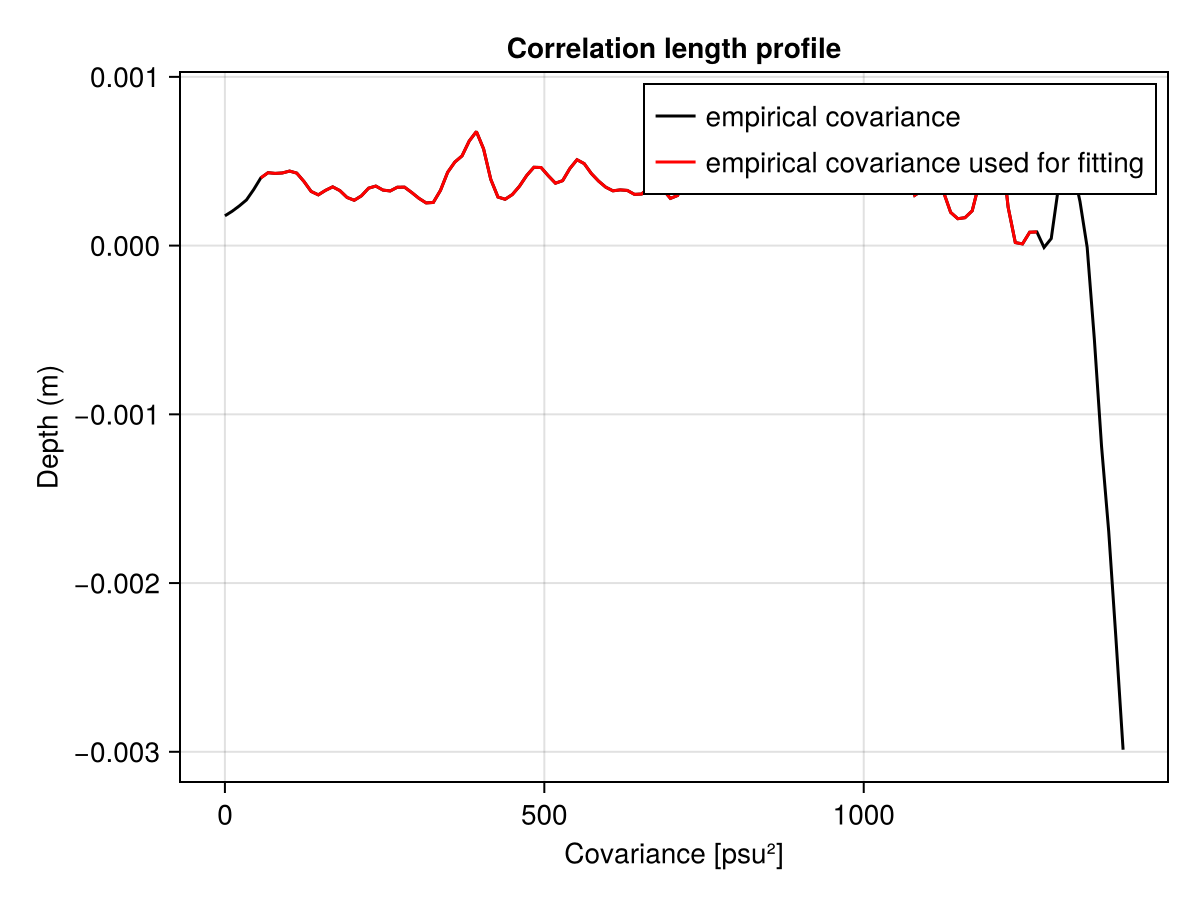

In [23]:
k = 45
covar = infoz[:fitinfos][k][:covar]
fitcovar = infoz[:fitinfos][k][:fitcovar]
distx = infoz[:fitinfos][k][:distx]
range = infoz[:fitinfos][k][:range]
rqual = infoz[:fitinfos][k][:rqual]

fig = Figure()
ax1 = Axis(fig[1, 1], ylabel = "Depth (m)", xlabel="Covariance [psu²]", 
title = "Correlation length profile")
lines!(ax1, distx,covar,label="empirical covariance", color=:black)
lines!(ax1, distx[range],covar[range], color=:red,label="empirical covariance used for fitting")
axislegend(ax1)
fig

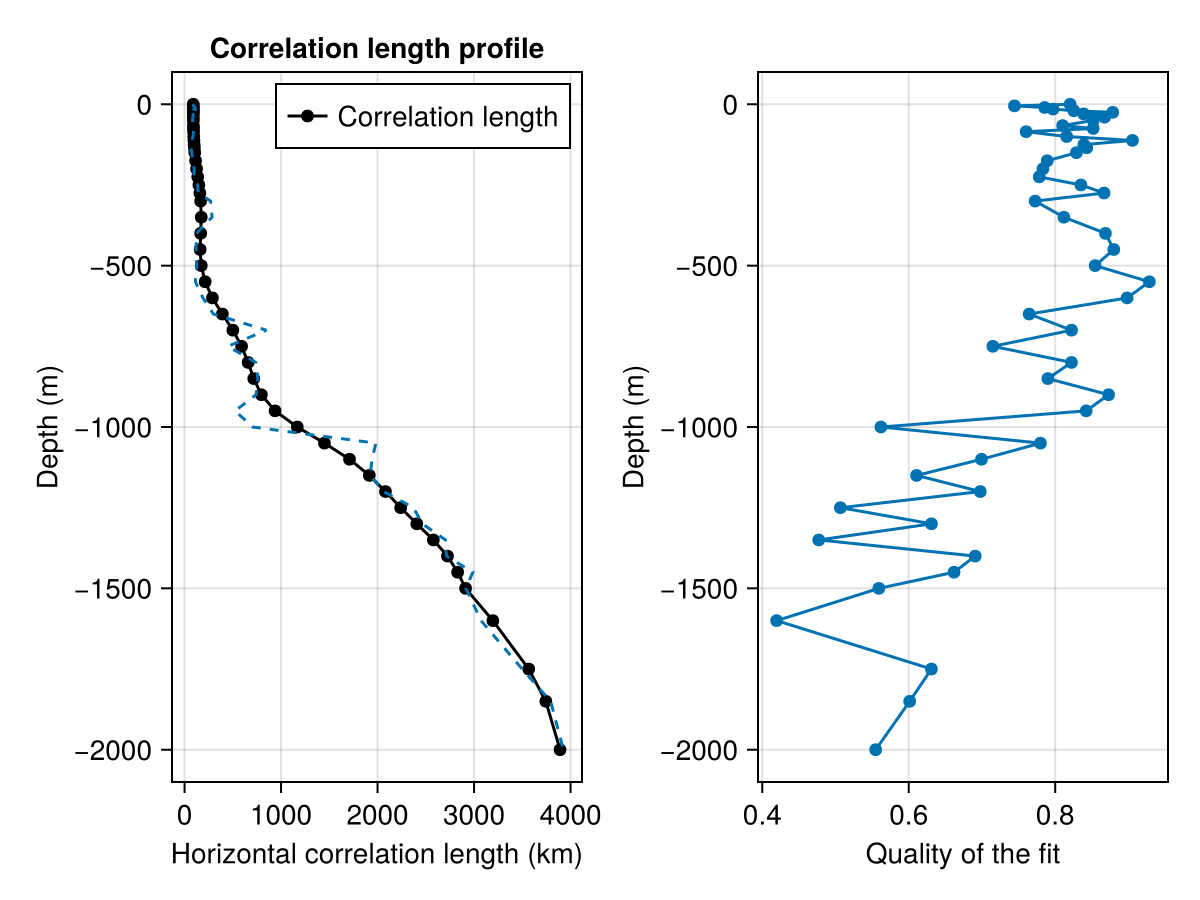

In [24]:
rqual = [f[:rqual] for f in infoz[:fitinfos]]

fig = Figure()
ax1 = Axis(fig[1, 1], ylabel = "Depth (m)", xlabel="Horizontal correlation length (km)", 
title = "Correlation length profile")
scatterlines!(ax1, lenz,-z, color=:black, label="Correlation length")
lines!(ax1, infoz[:len],-z, linestyle=:dash)
axislegend(ax1)

ax2 = Axis(fig[1, 2], ylabel = "Depth (m)", xlabel="Quality of the fit")
scatterlines!(ax2, rqual,-z)
fig

In [25]:
infoz[:fitinfos][end]

Dict{Symbol, Any} with 8 entries:
  :sn          => 0.0454973
  :rqual       => 0.554855
  :fitcovar    => [NaN, 0.000358416, 0.00035837, 0.0003583, 0.000358209, 0.0003…
  :meandist    => 1049.33
  :covar       => [0.00026754, 0.000243016, 0.000233089, 0.000225154, 0.0002089…
  :range       => 6:116
  :distx       => 0.0:15.991999999999999:1999.0
  :covarweight => [2.94379e17, 1.64706e18, 2.9539e17, 2.9437e17, 3.03807e19, 3.…

An alternative is to use of the vertical coordinate to obtain a reasonable guess of the vertical correlation

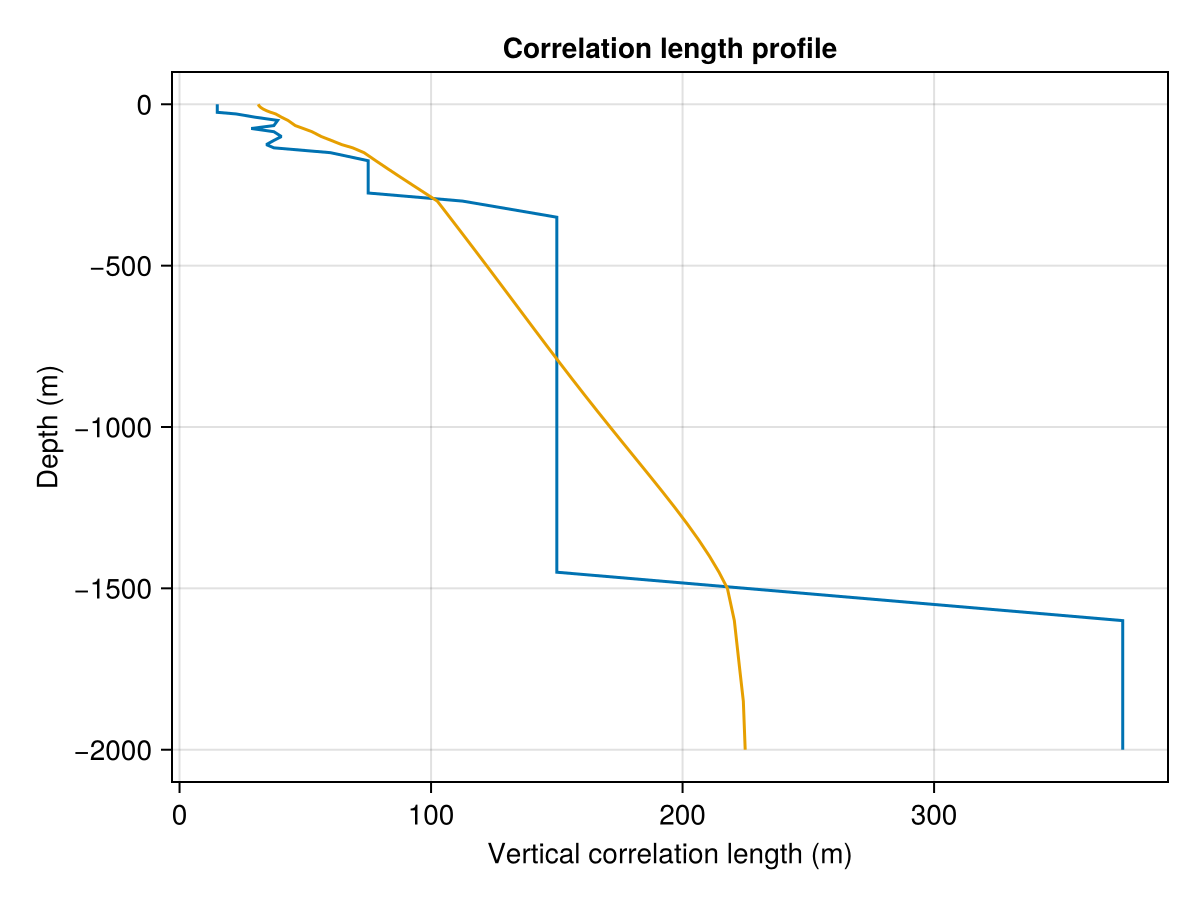

In [26]:
Dz = (z[3:end] - z[1:end-2])/2
lenz = 3 * [Dz[1], Dz..., Dz[end]]
lenzf = DIVAnd.smoothfilter(1:length(lenz),lenz,10)

fig = Figure()
ax1 = Axis(fig[1, 1], ylabel = "Depth (m)", xlabel="Vertical correlation length (m)", 
title = "Correlation length profile")
lines!(ax1, lenz,-z)
lines!(ax1, lenzf,-z);
fig